# **PIC 16B Final Project: Portfolio Optimization using Machine Learning**

### **Team Members:**
- Linzhi He
- Tim Li
- Michael Thompson

# Introduction
The purpose of this project is to develop a model that optimize portfolio selection based on projected risk and return. We aim to use different machine learning models and portfolio optimization techniques to find the optimal weight of a stock portfolio based in the US market. Our focus is on whether the advanced model will optimize portfolio selection and choose the best stock weight that gives the best return in the future.

# Context

In the world of finance, portfolio optimization and choosing the optimal weight to invest in each stock are crucial for maximizing returns and minimizing risks. In this project, we explore various models, including LSTM (Long Short-Term Memory), Random Forest, and Linear Regression, for return projection. Additionally, we implemented portfolio optimization techniques such as Mean-Variance Optimization, Advanced Mean-Variance Optimization (CVaR), Hierarchical Risk Parity, and the Black-Litterman Model. These models will ideally help us determine the best combination of stocks that will generate the least volatility (measured by standar deviation) and highest return in the future. In sights in this model will potentially help investors make better choices in balancing their portfolio based on unforeseen future risks.

# Loading Packages and Data
The stock market data is collected from the yfinance module from yahoo finance, which provides a complete and accurate data base of recent stock market information. Other required libraries include scikit-learn, tensorflow, seaborn, and PyPortfolioOpt

In [ ]:
#importing necessary packages and download new packages if needed
!pip install yfinance scikit-learn tensorflow seaborn PyPortfolioOpt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from scipy.optimize import minimize
from pypfopt import EfficientFrontier, risk_models, expected_returns, BlackLittermanModel, EfficientCVaR, HRPOpt, plotting
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from scipy.stats import uniform, randint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 621.9 kB/s eta 0:00:00


# Fetch and Preprocess Data
We defined an example of a list of diversified stocks to collect from Yahoo Finance. We adjusted for their closing prices and processed the data to prepare for the model. We choose 5 stocks as the default and choose example stocks to be public companies from various industries to provide an example of a relatively less correlated and diversified portfolio

In [ ]:
# Define the list of diversified stocks
diversified_list = ['MSFT', 'JNJ', 'JPM', 'AMZN', 'BA']

#alternative portfolio examples
#default example: ['MSFT', 'JNJ', 'JPM', 'AMZN', 'BA']
#tech focused: ['AAPL', 'GOOGL', 'META', 'NFLX', 'TSLA']
#consumer focused: ['KO', 'PG', 'PEP', 'WMT', 'MCD']

# Set up start and end times to collect data from
start = "2020-01-01"
end = "2024-04-01"

# Fetch and preprocess data
def fetch_data(stock_list, start, end):
    """
    Import adjusted closing price stocksdata from Yahoo Finance

    Args:
        stock_list (list): List of stock tickers collect
        start (str): Start date for the data (YYYY-MM-DD format)
        end (str): End date for the data (YYYY-MM-DD format)

    Returns:
        pd.DataFrame: DataFrame containing the adjusted closing prices stocks
    """
    data = yf.download(stock_list, start=start, end=end)
    # Forward fill to handle missing data
    data = data['Adj Close'].fillna(method='ffill')
    return data

def calculate_returns(data):
    """
    Calculates the daily percentage returns of stocks

    Args:
        data (pd DataFrame): DataFrame of stock prices and dates

    Returns:
        pd.DataFrame: DataFrame with daily percentage returns of stocks
    """
    returns = data.pct_change().dropna()
    return returns

In [ ]:
#we first collect the data from the data base and saves it
data = fetch_data(diversified_list, start, end)
data.head()

[*********************100%%**********************]  5 of 5 completed


Ticker,AMZN,BA,JNJ,JPM,MSFT
Date,,,,,
2020-01-02,94.900497,331.348572,129.055923,123.533585,154.215668
2020-01-03,93.748497,330.791901,127.561752,121.903419,152.295410
2020-01-06,95.143997,331.766083,127.402580,121.806480,152.689087
2020-01-07,95.343002,335.285156,128.180634,119.735695,151.296906
2020-01-08,94.598503,329.410095,128.162949,120.669754,153.706802


In [ ]:
#we also calculate returns for later use
returns = calculate_returns(data)
returns.head()

Ticker,AMZN,BA,JNJ,JPM,MSFT
Date,,,,,
2020-01-03,-0.012139,-0.001680,-0.011578,-0.013196,-0.012452
2020-01-06,0.014886,0.002945,-0.001248,-0.000795,0.002585
2020-01-07,0.002092,0.010607,0.006107,-0.017001,-0.009118
2020-01-08,-0.007809,-0.017523,-0.000138,0.007801,0.015928
2020-01-09,0.004799,0.014998,0.002966,0.003651,0.012493


We then iterated over each column in the provided data, plotting the adjusted closing prices of each stock against the dates. Each stock's prices were plotted with a distinct line and labeled with the stock's name for clarity. The plot was given a title, "Stock Closing Prices," and the x-axis and y-axis were labeled as "Date" and "Adjusted Closing Price," respectively. We also added a legend to differentiate between the stocks. Finally, we displayed the plot using plt.show(). This function was called with the data to generate the visualization of stock closing prices.

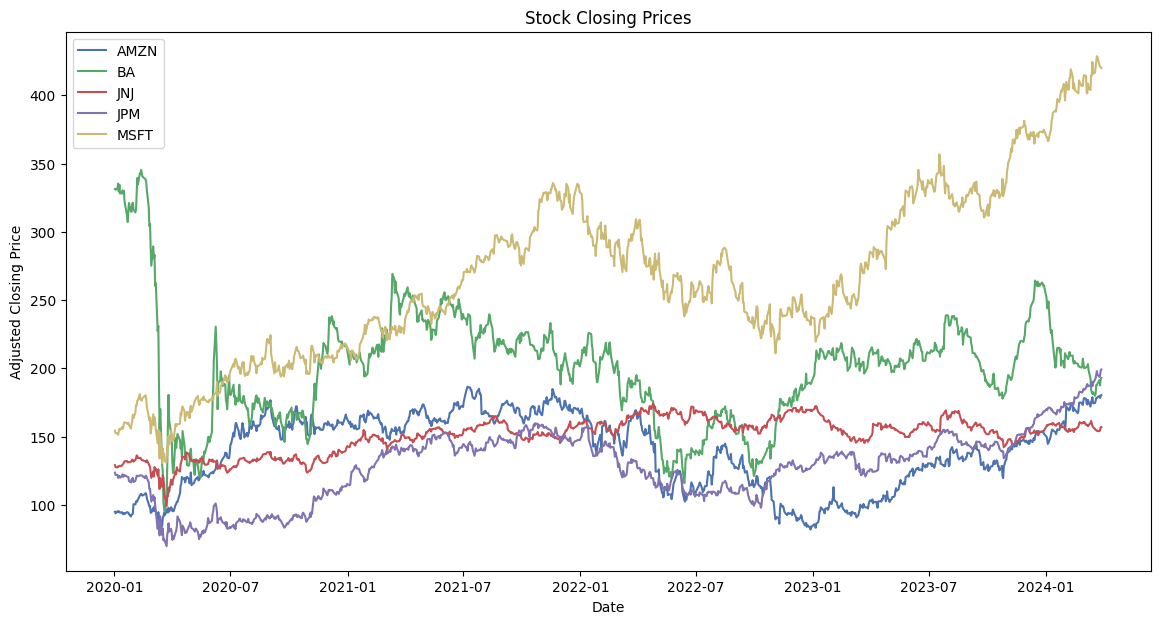

In [ ]:
# Plot closing prices
def plot_closing_prices(data):
    """
    Plot adjusted closing prices of stocks

    Args:
        data (pd.DataFrame): DataFrame containing stock prices and dates

    Returns:
        None
    """
    plt.figure(figsize=(14, 7))

    #plot each column in the dataframe
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    #add labels for plot
    plt.title('Stock Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Closing Price')
    plt.legend()
    plt.show()

plot_closing_prices(data)

We then created a scatter plot where each point represents a stock, with the x-axis showing the expected return (mean of returns) and the y-axis showing the risk (standard deviation of returns). The size of each point is determined by the area variable. To make the plot more informative, we annotated each point with the corresponding stock label using a blue arrow for clarity. The annotations are positioned slightly offset from the points to avoid overlap, ensuring that the plot remains readable. Finally, we displayed the plot using plt.show().



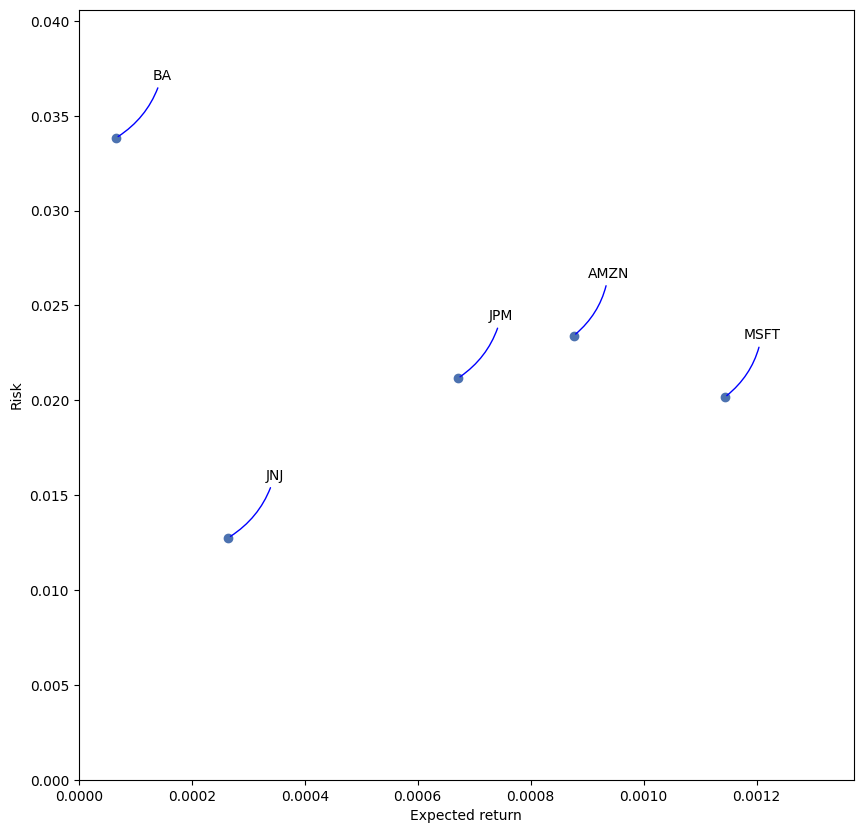

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(returns.mean(), returns.std())
plt.xlabel('Expected return')
plt.ylabel('Risk')
plt.xlim(0, returns.mean().max() * 1.2)
plt.ylim(0, returns.std().max() * 1.2)

for label, x, y in zip(returns.columns, returns.mean(), returns.std()):
    plt.annotate(label, xy=(x, y), xytext=(40, 40), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.2'))
plt.show()

Each subplot was populated with the daily return data for a specific company, plotted with a dashed line and markers. The subplots were titled with the corresponding company names. Finally, we adjusted the layout using tight_layout() and displayed the plot with plt.show(). We also removed the extra subplot if the number of companies was odd to ensure a clean presentation.

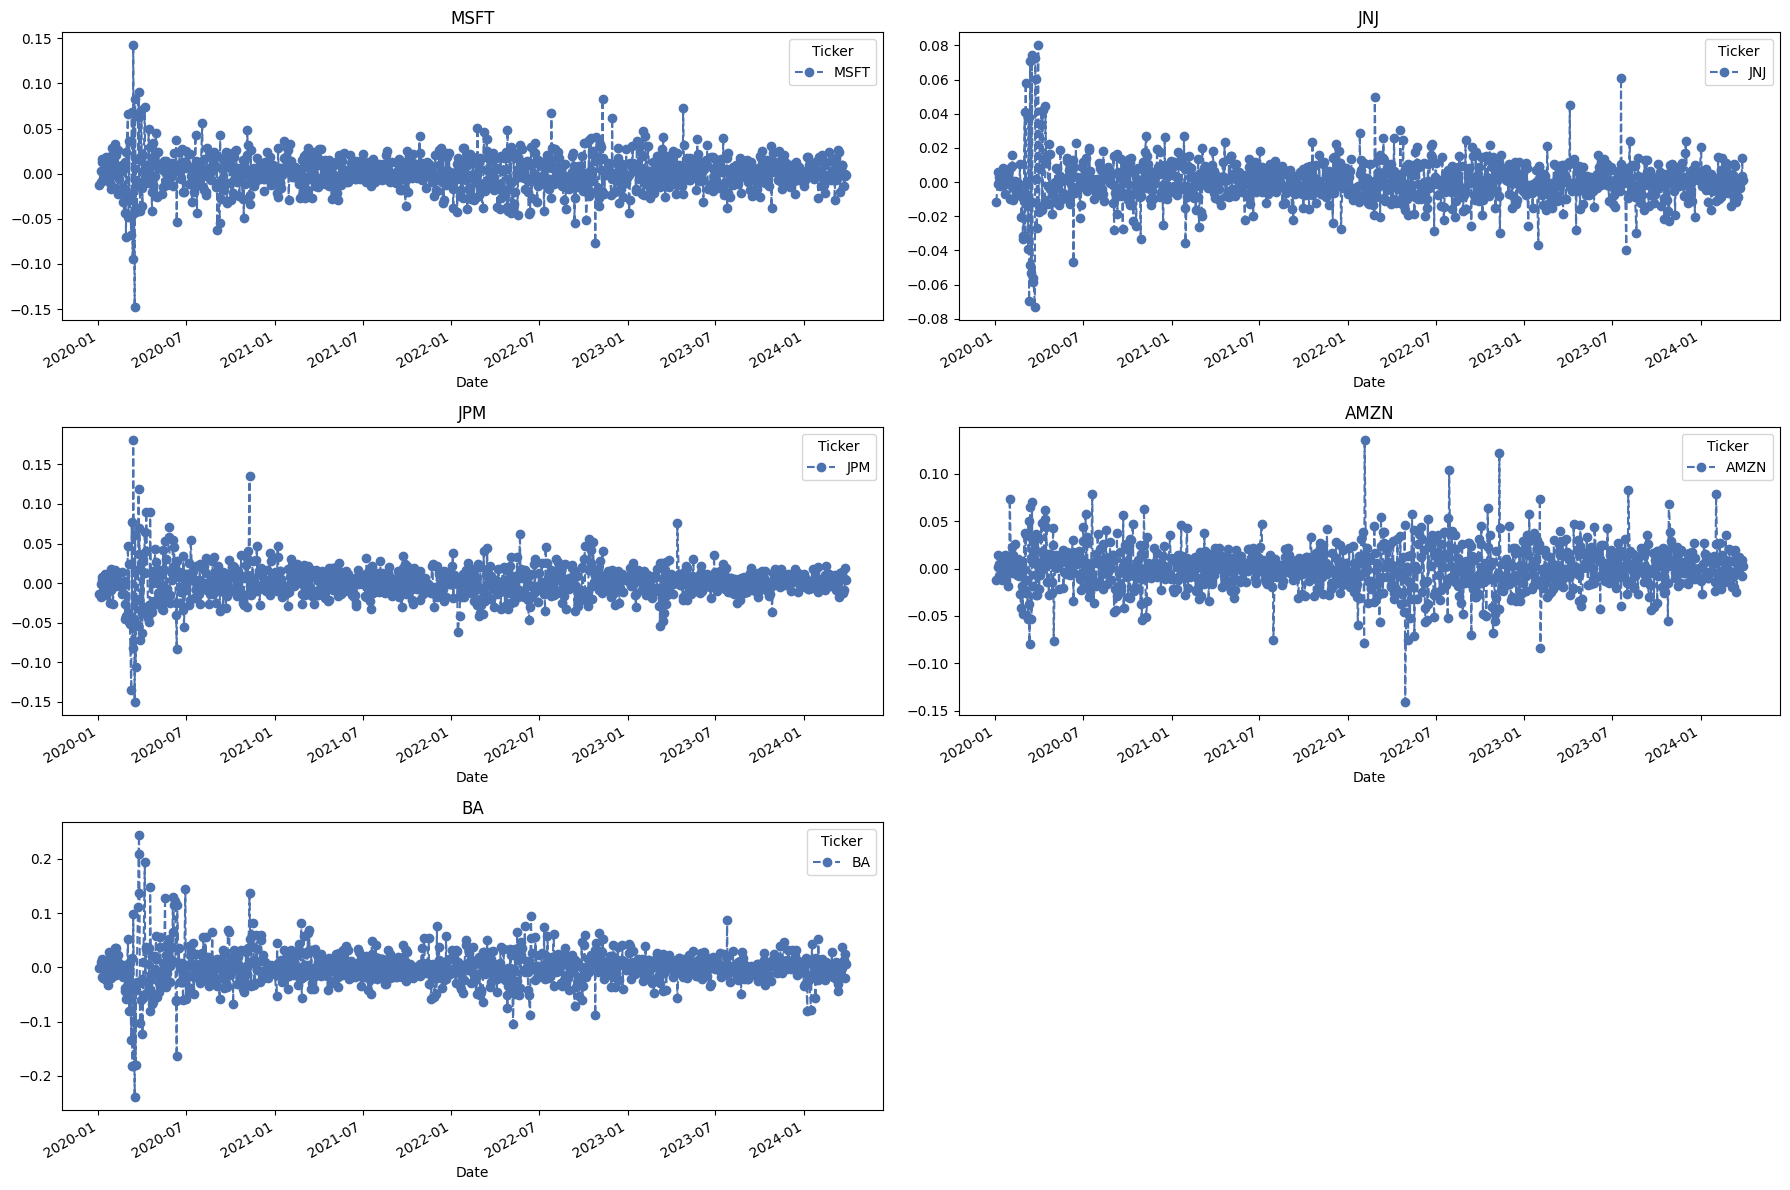

In [ ]:
# Convert returns DataFrame to dictionary of DataFrames for plotting
company_list = {symbol: returns[[symbol]].copy() for symbol in diversified_list}

# Plotting daily return percentage
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

# plot in different subplots
for i, symbol in enumerate(diversified_list):
    row = i // 2
    col = i % 2
    company_list[symbol].plot(ax=axes[row, col], legend=True, linestyle='--', marker='o')
    axes[row, col].set_title(symbol)

# Remove the empty subplot if the number of companies is odd
if len(diversified_list) % 2 != 0:
    fig.delaxes(axes[2, 1])

fig.tight_layout()
plt.show()

# Prepare data for LSTM model
We defined a function, create_sequences, to generate sequences of data for the LSTM model. This function takes in the data and a specified sequence length. It iterates through the data, creating sequences of sequence_length consecutive data points and corresponding targets, which are the data points immediately following each sequence. The function returns these sequences and targets as NumPy arrays. Additionally, we set the sequence length to 60, which means each sequence will consist of 60 data points.

In [ ]:
# Create sequences for LSTM model
def create_sequences(data, sequence_length):
    """
    Create data sequence for time series prediction

    Args:
        data (np array or pd Series): array or series containing the time series data
        sequence_length (int): length of each sequence

    Returns:
        tuple: tuple containing numpy arrays, X (features) and y (labels)
    """
    X, y = [], []
    # determine the sequence length for LSTM
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60

We initialized a MinMaxScaler to normalize the returns data, ensuring that all values fall within a specific range. We then applied this scaler to the returns data, transforming it into scaled data. Using the create_sequences function defined earlier, we generated the sequences (X) and targets (y) from the scaled data based on the specified sequence length.
Why initialize using MinMaxScaler is because it is particularly advantageous for LSTM models because it normalizes the input data, making the activation functions (like tanh and sigmoid) more effective, which enhances model performance and convergence speed. This method preserves the relationships between data points, crucial for capturing trends and patterns in time series data. Additionally, it manages the non-stationarity common in financial data, ensuring consistency for the model. By scaling all features between 0 and 1, it prevents discrepancies in value ranges, ensuring equal contribution to the model and avoiding dominance by larger values. This normalization also improves computational efficiency and stability, reducing the risk of numerical issues during training.

In [ ]:
# Data standardization using Min Max Scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(returns.values)
X, y = create_sequences(scaled_data, sequence_length)
y = y.reshape(-1, y.shape[1])
#print data shape
X.shape, y.shape

((1006, 60, 5), (1006, 5))

#Split data into training and testing sets

We first split into training (80%) and testing/validation (20%) sets to train the model and evaluate its performance on unseen data, respectively. The testing dates are then extracted to align predictions with actual dates for evaluation purposes. This validation set is also used to tune hyperparameters and validate the model during training, helping to prevent overfitting and ensuring the model performs well on both the training and validation sets.

In [ ]:
# data is split based on 80% training and 20% testing ratio
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [ ]:
# print data shape
X_train.shape, X_train.shape, y_val.shape, y_val.shape

((804, 60, 5), (804, 60, 5), (202, 5), (202, 5))

In [ ]:
#separate out the test dates for plotting
test_dates = returns.index[split_index + sequence_length:]

# Build and Train the LSTM Model

We start by importing the necessary libraries, including TensorFlow for building and training the LSTM model, and scikit-learn and scipy for hyperparameter sampling. The function build_and_train_lstm is defined to construct and train an LSTM model with specified hyperparameters. It creates a sequential model with two LSTM layers, each with a specified number of units, followed by a dense layer with a specified number of units. The model is compiled using the Adam optimizer with a specified learning rate and a mean squared error loss function. Early stopping is implemented to monitor the validation loss, with a patience of 5 epochs, restoring the best weights.

Next, we define the hyperparameter space using dictionaries and specify the number of hyperparameter combinations to try (n_iter). The Random Search process iterates over sampled combinations of hyperparameters, training a model for each combination and recording its validation loss. The model with the lowest validation loss is selected as the best model.

After identifying the best hyperparameters, the best model is retrained on the training data and validated on the validation data with early stopping. The final model is then used to predict returns on the test data, and the predicted returns are inverse transformed to their original scale using the scaler. Finally, we display a sample of the predicted returns from the LSTM model to verify the results.

In [ ]:
def build_and_train_lstm(X_train, y_train, X_val, y_val, params):
    """
    Builds and trains an LSTM model for time series forecasting.

    Args:
        X_train (np array): training data features
        y_train (np array): training data targets
        X_test (np array): test data features
        y_test (np array): test data target
        params (dict): dictionary with model hyperparameters:
            - lstm_units (int): number of LSTM units
            - dense_units (int): number of dense layer units
            - learning_rate (float): learning rate
            - batch_size (int): batch size for model

    Returns:
        tuple: trained model and final validation loss
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(params['lstm_units'], return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dense(params['dense_units']),
        tf.keras.layers.Dense(X_train.shape[2])  # output layer matching the input features
    ])
    # compile the model based on the parameters
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='mean_squared_error')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=5,
                                                      restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=params['batch_size'],
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0)
    return model, history.history['val_loss'][-1]

In [ ]:
# Hyperparameter space
param_distributions = {
    'lstm_units': randint(20, 100),
    'dense_units': randint(10, 50),
    'learning_rate': uniform(0.0001, 0.01),
    'batch_size': randint(16, 128)
}

# Number of parameter combinations to try
n_iter = 10

# Random Search
best_val_loss = float('inf')
best_params = None
best_model = None

#choose the optimial parameters based on the loss
for params in list(ParameterSampler(param_distributions, n_iter=n_iter)):
    model, val_loss = build_and_train_lstm(X_train, y_train, X_val, y_val, params)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model

print("Best hyperparameters:", best_params)

Best hyperparameters: {'batch_size': 121, 'dense_units': 18, 'learning_rate': 0.007819828751374608, 'lstm_units': 35}


In [ ]:
# Train the best model
best_model.fit(X_train, y_train, epochs=10, batch_size=best_params['batch_size'],
               validation_data=(X_val, y_val),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           restore_best_weights=True)],
               verbose=1)
predicted_returns_lstm = best_model.predict(X_val)
predicted_returns_lstm = scaler.inverse_transform(predicted_returns_lstm)

# Display sample predicted returns from the LSTM model
print("Sample predicted returns from LSTM model:")
print(predicted_returns_lstm[:5])

Epoch 1/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 2/10
7/7 [==============================] - 0s 44ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 3/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 4/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 5/10
7/7 [==============================] - 0s 40ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 6/10
7/7 [==============================] - 0s 45ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 7/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 8/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 9/10
7/7 [==============================] - 1s 8ms/step
Sample predicted returns from LSTM model:
[[0.0037241  0.00056055 0.00159001 0.00179501 0.00302612]
 [0.00380275 0.00183613 0.00143122 0.00243025 0.00366795]
 [0.

# Portfolio Optimization methods
We explored different portfolio optimization techniques to find the best combination

### Mean-Variance Optimization (MVO)

We first implement Mean-Variance Optimization to determine the optimal portfolio allocation based on the expected returns and covariance matrix of the assets. This approach aims to maximize the Sharpe ratio, which is the return-to-risk ratio.

In [ ]:
def mean_variance_optimization(expected_returns, cov_matrix, allow_short=False):
    """
    Perform mean-variance optimization to find optimal portfolio weights

    Args:
        expected_returns (np array): expected returns for each stock
        cov_matrix (np array): covariance matrix of stock returns
        allow_short (bool): if allowing short selling (default is False)

    Returns:
        np.array: optimal asset weights.
    """
    num_assets = len(expected_returns)

    def portfolio_performance(weights):
        """
        Calculates the performance of a portfolio given its weights.

        Args:
            weights (np array): Array of asset weights in portfolio.

        Returns:
            float: negative Sharpe ratio
        """
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        # minimize the negative Sharpe ratio for profit maximization
        return -returns / volatility

    #set the constraints to ensure weight sums to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    #change weight according to if short selling is allowed (allowing negative weight)
    bounds = tuple((-1, 1) for _ in range(num_assets)) if allow_short else tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets]

    optimized = minimize(portfolio_performance,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
    return optimized.x

#execute the LSTM model
expected_returns_lstm = np.mean(predicted_returns_lstm, axis=0)
cov_matrix = returns.cov().values

#choose the optimal weights
optimal_weights_mvo = mean_variance_optimization(expected_returns_lstm, cov_matrix, allow_short=True)
print(f"Optimal Weights (MVO): {optimal_weights_mvo.round(2)}")

Optimal Weights (MVO): [ 0.22 -0.56 -0.25  0.88  0.71]


### Evaluating MVO performance

After determining the optimal portfolio weights using Mean-Variance Optimization (MVO), we evaluate the portfolio's performance on the test data. We calculating the returns of the portfolio over the test period and computing the cumulative returns to understand the portfolio's growth.

Specifically, Mean-Variance Optimization (MVO) is a method that constructs an optimal investment portfolio by maximizing expected returns for a given level of risk or minimizing risk for a given level of expected returns. It calculates the expected returns, variances, and covariances of asset returns to find the best trade-off between risk and return. This process identifies the efficient frontier, which represents the set of portfolios offering the highest return for a given risk level. Investors use this information to select a portfolio that aligns with their risk tolerance and return objectives.

In [ ]:
# Evaluate the portfolio on test data
def evaluate_portfolio(test_data, weights):
    """
    Evaluates portfolio performance with test data and weights

    Args:
        test_data (pd DataFrame): DataFrame containing test period stock price
        weights (np array): array of asset weights

    Returns:
        tuple: Cumulative returns, daily portfolio total returns
    """
    test_returns = calculate_returns(test_data)
    portfolio_returns = (test_returns * weights).sum(axis=1)

    # Start with $100 investment as benchmark
    cumulative_returns = (1 + portfolio_returns).cumprod() * 100
    return cumulative_returns, portfolio_returns

#select tge test data length and calculate returns
test_data = data.iloc[split_index + sequence_length:]
cumulative_returns_mvo, portfolio_returns_mvo = evaluate_portfolio(test_data, optimal_weights_mvo)

# Display sample cumulative returns for MVO
print("Sample cumulative returns for MVO:")
print(cumulative_returns_mvo.head())

Sample cumulative returns for MVO:
Date
2023-06-09    100.603832
2023-06-12    101.190958
2023-06-13    102.542589
2023-06-14    103.591293
2023-06-15    106.061919
dtype: float64


### Advanced Mean Variance Optimization (Advanced MVO) using CVaR

Conditional Value at Risk (CVaR) is an advanced risk measure that focuses on the tail end of the loss distribution, providing a better understanding of extreme losses. Here, we implement CVaR-based optimization to determine the optimal portfolio weights, trying to minimize potential extreme losses.

In [ ]:
# Advanced Mean-Variance Optimization using CVaR
def advanced_mean_variance_optimization(expected_returns, returns):
    """
    Execute advanced mean-variance optimization model using Conditional Value at Risk (CVaR)

    Args:
        expected_returns (pd Series): expected returns for each asset
        returns (pd DataFrame): DataFrame containing historical stock returns

    Returns:
        dict: Optimized asset weights using CVaR minimization
    """
    S = risk_models.sample_cov(returns)
    ef_cvar = EfficientCVaR(expected_returns, returns)
    weights_cvar = ef_cvar.min_cvar()
    cleaned_weights_cvar = ef_cvar.clean_weights()
    return cleaned_weights_cvar

#execute the AMVO model
cleaned_weights_cvar = advanced_mean_variance_optimization(expected_returns_lstm, returns)

print(f"Optimized weights (AMVO - CVaR): {cleaned_weights_cvar}")

Optimized weights (AMVO - CVaR): OrderedDict([(0, 0.14965), (1, 0.0), (2, 0.75739), (3, 0.057), (4, 0.03596)])


In [ ]:
# Display sample cumulative returns for AMVO - CVaR
cumulative_returns_cvar, portfolio_returns_cvar = evaluate_portfolio(test_data, list(cleaned_weights_cvar.values()))

print("Sample cumulative returns for AMVO - CVaR:")
print(cumulative_returns_cvar.head())

Sample cumulative returns for AMVO - CVaR:
Date
2023-06-09     99.811348
2023-06-12    100.194528
2023-06-13    100.671655
2023-06-14    101.043699
2023-06-15    102.335157
dtype: float64


### Hierarchical Risk Parity

We implemented the Hierarchical Risk Parity (HRP) method to optimize the portfolio allocation by leveraging hierarchical clustering, which groups assets with similar return patterns, to minimize risk without needing to invert the covariance matrix. We first created an HRP optimization object using the historical returns, allowing the HRP algorithm to balance risk across identified clusters. Next, we optimized the portfolio weights with the HRP method to ensure a stable and diversified allocation. Finally, we evaluated the portfolio's performance on the test data by calculating the daily and cumulative returns, thereby assessing the effectiveness of the HRP method in managing risk and returns during the test period.

In [ ]:
# Hierarchical Risk Parity
def hierarchical_risk_parity(returns):
    """
    Execute Hierarchical Risk Parity (HRP) optimization on stock

    Args:
        returns (pd DataFrame): DataFrame containing the stock returns

    Returns:
        dict: dictionary of optimized portfolio weights
    """
    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()
    return hrp_weights

#execute the hrp model and print result
hrp_weights = hierarchical_risk_parity(returns)
print(f"Optimized weights (HRP): {hrp_weights}")

Optimized weights (HRP): OrderedDict([('AMZN', 0.15901838234737287), ('BA', 0.03860479007391743), ('JNJ', 0.5357314719025675), ('JPM', 0.09865644078231203), ('MSFT', 0.16798891489383014)])


In [ ]:
# Display sample cumulative returns for HRP
cumulative_returns_hrp, portfolio_returns_hrp = evaluate_portfolio(test_data, list(hrp_weights.values()))
print("Sample cumulative returns for HRP:")
print(cumulative_returns_hrp.head())

Sample cumulative returns for HRP:
Date
2023-06-09     99.895975
2023-06-12    100.597860
2023-06-13    101.067724
2023-06-14    101.369576
2023-06-15    102.888517
dtype: float64


### Black-Litterman Model
We started by calculating the expected returns (mu) using the mean_historical_return function and the sample covariance matrix (S) using the sample_cov function, which give us the historical estimates of returns and risk. Next, we used the market returns as our prior view by calculating the market-implied returns (market_prior) with the capm_return function. We then created the Black-Litterman model by blending these market views with the historical data, using the sample covariance matrix and the market-implied returns as both the prior and absolute views. From this model, we obtained the adjusted returns (bl_return). We constructed an efficient frontier with these adjusted returns and the sample covariance matrix, allowing for short selling by setting weight_bounds=(-1, 1). We optimized the portfolio to maximize the Sharpe ratio, resulting in the optimized weights, which were then cleaned for interpretability. Finally, we evaluated the portfolio's performance using these optimized weights on the test data, calculating the cumulative and portfolio returns to assess performance. We printed the optimized weights to understand the final asset allocation in the portfolio.

In [ ]:
# Black-Litterman Model with equal weight
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)
market_prior = expected_returns.capm_return(data)
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=market_prior)
bl_return = bl.bl_returns()
ef_bl = EfficientFrontier(bl_return, S, weight_bounds=(-1, 1))  # Allow for negative weights
weights_bl = ef_bl.max_sharpe()
cleaned_weights_bl = ef_bl.clean_weights()
print(f"Optimized weights (Black-Litterman): {cleaned_weights_bl}")

Optimized weights (Black-Litterman): OrderedDict([('AMZN', 0.2), ('BA', 0.2), ('JNJ', 0.2), ('JPM', 0.2), ('MSFT', 0.2)])


In [ ]:
# Display sample cumulative returns for Black-Litterman
cumulative_returns_bl, portfolio_returns_bl = evaluate_portfolio(test_data, list(cleaned_weights_bl.values()))
print("Sample cumulative returns for Black-Litterman:")
print(cumulative_returns_bl.head())

Sample cumulative returns for Black-Litterman:
Date
2023-06-09     99.897323
2023-06-12    101.090544
2023-06-13    101.398370
2023-06-14    101.252512
2023-06-15    102.744292
dtype: float64


# Additional Models for Return Prediction
We implement additional models like Random Forest and Linear Regression to help with return prediction and portfolio optimization. The random forest and linear regression models are used as additional methods to predict return, which is then applied to the MVO optimization methods for finding the optimal portfolio.


### Random Forest

We implemented hyperparameter tuning for an RNN model using Random Search to identify the best combination of hyperparameters, including the number of RNN units, dense units, learning rate, and batch size. The build_and_train_rnn function constructs an RNN model with specified hyperparameters, trains it with early stopping to monitor validation loss, and returns the model along with the final validation loss. The hyperparameter space is defined, and Random Search is performed over 10 iterations to sample different hyperparameter combinations. The model with the lowest validation loss is selected as the best model. This best model is then retrained on the full training data and used to predict returns on the test data, with the predicted returns inverse transformed to their original scale for interpretation. A sample of these predicted returns is displayed to verify the model's performance.

In [ ]:
# This model is used to test on other RNN approaches, however, it is not used due to low accuracy
def build_and_train_rnn(X_train, y_train, X_val, y_val, rnn_units, dense_units, learning_rate, batch_size):
    """
    Build and train a Recurrent Neural Network (RNN) model for stocks

    Args:
        X_train (np array): training data features
        y_train (np array): training data target
        X_val (np array): validation data features
        y_val (np array): validation data target
        rnn_units (int): number of units in the RNN layer
        dense_units (int): number of units in the dense layer
        learning_rate (float): learning rate
        batch_size (int): batch size for training

    Returns:
        tuple: tuple of trained model and final validation loss
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(rnn_units, return_sequences=False,
                                  input_shape=(X_train.shape[1],
                                               X_train.shape[2])),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1])  # Adjust output layer to match the target shape
    ])

    #compile the model and fit it to dataset
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=5,
                                                      restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0)
    return model, history.history['val_loss'][-1]

In [ ]:
# Hyperparameter space
param_distributions = {
    'rnn_units': randint(20, 100),
    'dense_units': randint(10, 50),
    'learning_rate': uniform(0.0001, 0.01),
    'batch_size': randint(16, 128)
}

# Number of parameter combinations to try
n_iter = 10

# Random Search
best_val_loss = float('inf')
best_params = None
best_model = None

for params in list(ParameterSampler(param_distributions,
                                    n_iter=n_iter)):
    model, val_loss = build_and_train_rnn(X_train, y_train,
                                          X_val, y_val, **params)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model

print("Best hyperparameters for RNN:", best_params)

Best hyperparameters for RNN: {'batch_size': 57, 'dense_units': 44, 'learning_rate': 0.0020435463714439084, 'rnn_units': 60}


In [ ]:
# Train the best model
best_model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'],
               validation_data=(X_val, y_val),
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           restore_best_weights=True)],
               verbose=1)

#predict on the X validation data
predicted_returns_rnn = best_model.predict(X_val)
predicted_returns_rnn = scaler.inverse_transform(predicted_returns_rnn)


# Display sample predicted returns from the RNN model
print("Sample predicted returns from RNN model:")
print(predicted_returns_rnn)

Epoch 1/20
15/15 [==============================] - 0s 23ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 3/20
15/15 [==============================] - 0s 20ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 4/20
15/15 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 5/20
15/15 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 6/20
15/15 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 7/20
15/15 [==============================] - 0s 18ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 8/20
15/15 [==============================] - 0s 17ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 9/20
15/15 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 10/20
15/15 [==============================] - 0s 24ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 11/

In [ ]:
# Random Forest Model for return prediction
rf_model = RandomForestRegressor(n_estimators=100, random_state=8)
X_rf_train = X_train.reshape((X_train.shape[0], -1))
X_rf_test = X_val.reshape((X_val.shape[0], -1))
rf_model.fit(X_rf_train, y_train)
predicted_returns_rf = rf_model.predict(X_rf_test)
predicted_returns_rf = scaler.inverse_transform(predicted_returns_rf)

#calculate mean returns and weights
expected_returns_rf = np.mean(predicted_returns_rf, axis=0)
optimal_weights_rf = mean_variance_optimization(expected_returns_rf,
                                                cov_matrix,
                                                allow_short=True)

print(f"Optimal Weights (RF): {optimal_weights_rf.round(2)}")

Optimal Weights (RF): [-0.48 -0.12  0.21  0.39  1.  ]


In [ ]:
# Display sample cumulative returns for Random Forest
cumulative_returns_rf, portfolio_returns_rf = evaluate_portfolio(test_data,
                                                                 optimal_weights_rf)
print("Sample cumulative returns for Random Forest:")
print(cumulative_returns_rf.head())

Sample cumulative returns for Random Forest:
Date
2023-06-09    100.879102
2023-06-12    100.940199
2023-06-13    102.112506
2023-06-14    103.296547
2023-06-15    106.927961
dtype: float64


### Linear Regression

We finally defining a Linear Regression model and fitting it to the training data, which had been reshaped appropriately. We then used the fitted model to predict returns on the test data. To convert these predicted returns back to their original scale, we applied the inverse transformation using our scaler. Next, we calculated the expected returns by averaging the predicted returns. Utilizing these expected returns and the covariance matrix, we performed mean-variance optimization to determine the optimal portfolio weights, allowing for short positions. Finally, we evaluated the portfolio's performance by calculating the cumulative and individual returns based on the test data and the optimal weights obtained.

In [ ]:
# Linear Regression Model for return prediction
lr_model = LinearRegression()
lr_model.fit(X_rf_train, y_train)
predicted_returns_lr = lr_model.predict(X_rf_test)
predicted_returns_lr = scaler.inverse_transform(predicted_returns_lr)

expected_returns_lr = np.mean(predicted_returns_lr, axis=0)
optimal_weights_lr = mean_variance_optimization(expected_returns_lr, cov_matrix, allow_short=True)
print(f"Optimal Weights (LR): {optimal_weights_lr.round(2)}")
cumulative_returns_lr, portfolio_returns_lr = evaluate_portfolio(test_data, optimal_weights_lr)

Optimal Weights (LR): [-0.57  0.37  0.29 -0.09  1.  ]


In [ ]:
# Display sample cumulative returns for Linear Regression
print("Sample cumulative returns for Linear Regression:")
print(cumulative_returns_lr.head())

Sample cumulative returns for Linear Regression:
Date
2023-06-09    100.651638
2023-06-12    101.445255
2023-06-13    102.044740
2023-06-14    102.680112
2023-06-15    106.372784
dtype: float64


# Evaluation and Data Visualization
We evaluated the prediction accuracy and visualized the portfolio performance of the models

We define a function to calculate prediction accuracy metrics, including mean squared error (MSE), root mean squared error (RMSE), and R-squared (R²). We then used this function to evaluate the prediction accuracy of our LSTM, Random Forest, and Linear Regression models against the test data. Next, we defined another function to calculate additional performance metrics for portfolio returns, including the Sharpe ratio, annualized return rate, annualized risk, and maximum drawdown. We computed these metrics for various portfolio optimization strategies used before, including MVO, AMVO - CVaR, HRP, Black-Litterman, Random Forest, and Linear Regression. Finally, we displayed the results of these metrics for each strategy, providing a comprehensive view of their performance in terms of return, risk, and drawdown.

In [ ]:
# Calculate prediction accuracy
def calculate_accuracy(y_true, y_pred):
    """
    calculate the accuracy metrics of models

    Args:
        y_true (np array): true values
        y_pred (np array): predicted values.

    Returns:
        tuple: mean squared error (mse), root mean squared error (rmse), and R-squared (r2)
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

mse_lstm, rmse_lstm, r2_lstm = calculate_accuracy(y_val, predicted_returns_lstm)
mse_rf, rmse_rf, r2_rf = calculate_accuracy(y_val, predicted_returns_rf)
mse_lr, rmse_lr, r2_lr = calculate_accuracy(y_val, predicted_returns_lr)

In [ ]:
# Additional performance metrics
def calculate_metrics(portfolio_returns):
    """
    Calculate performance metrics for the portfolio

    Args:
        portfolio_returns (pd Series): Series of portfolio returns

    Returns:
        tuple: Sharpe ratio, annualized return rate, annualized risk, and maximum drawdown
    """
    risk_free_rate = 0.01
    sharpe_ratio = (portfolio_returns.mean() - risk_free_rate) / portfolio_returns.std()
    return_rate = portfolio_returns.mean() * 252  # annualized
    risk = portfolio_returns.std() * np.sqrt(252)  # annualized
    max_drawdown = (portfolio_returns.cummin() - portfolio_returns.cummax()).min()
    return sharpe_ratio, return_rate, risk, max_drawdown

sharpe_ratio_mvo, return_rate_mvo, risk_mvo, max_drawdown_mvo = calculate_metrics(portfolio_returns_mvo)
sharpe_ratio_cvar, return_rate_cvar, risk_cvar, max_drawdown_cvar = calculate_metrics(portfolio_returns_cvar)
sharpe_ratio_hrp, return_rate_hrp, risk_hrp, max_drawdown_hrp = calculate_metrics(portfolio_returns_hrp)
sharpe_ratio_bl, return_rate_bl, risk_bl, max_drawdown_bl = calculate_metrics(portfolio_returns_bl)
sharpe_ratio_rf, return_rate_rf, risk_rf, max_drawdown_rf = calculate_metrics(portfolio_returns_rf)
sharpe_ratio_lr, return_rate_lr, risk_lr, max_drawdown_lr = calculate_metrics(portfolio_returns_lr)

# Display results
print(f"Sharpe Ratio (MVO): {sharpe_ratio_mvo}, Return Rate (MVO): {return_rate_mvo}, Risk (MVO): {risk_mvo}, Max Drawdown (MVO): {max_drawdown_mvo}")
print(f"Sharpe Ratio (AMVO - CVaR): {sharpe_ratio_cvar}, Return Rate (AMVO - CVaR): {return_rate_cvar}, Risk (AMVO - CVaR): {risk_cvar}, Max Drawdown (AMVO - CVaR): {max_drawdown_cvar}")
print(f"Sharpe Ratio (HRP): {sharpe_ratio_hrp}, Return Rate (HRP): {return_rate_hrp}, Risk (HRP): {risk_hrp}, Max Drawdown (HRP): {max_drawdown_hrp}")
print(f"Sharpe Ratio (Black-Litterman): {sharpe_ratio_bl}, Return Rate (Black-Litterman): {return_rate_bl}, Risk (Black-Litterman): {risk_bl}, Max Drawdown (Black-Litterman): {max_drawdown_bl}")
print(f"Sharpe Ratio (RF): {sharpe_ratio_rf}, Return Rate (RF): {return_rate_rf}, Risk (RF): {risk_rf}, Max Drawdown (RF): {max_drawdown_rf}")
print(f"Sharpe Ratio (LR): {sharpe_ratio_lr}, Return Rate (LR): {return_rate_lr}, Risk (LR): {risk_lr}, Max Drawdown (LR): {max_drawdown_lr}")

Sharpe Ratio (MVO): -0.3776771895694765, Return Rate (MVO): 0.833848686863406, Risk (MVO): 0.28123898313352785, Max Drawdown (MVO): -0.13412749187380485
Sharpe Ratio (AMVO - CVaR): -1.1951938080059388, Return Rate (AMVO - CVaR): 0.1338695295794135, Risk (AMVO - CVaR): 0.12576377986323692, Max Drawdown (AMVO - CVaR): -0.06827944488283975
Sharpe Ratio (HRP): -1.2913197820123798, Return Rate (HRP): 0.1953249128161321, Risk (HRP): 0.11340395132746273, Max Drawdown (HRP): -0.04455026692872652
Sharpe Ratio (Black-Litterman): -1.1495002520558817, Return Rate (Black-Litterman): 0.25049800461131205, Risk (Black-Litterman): 0.12437160179627559, Max Drawdown (Black-Litterman): -0.040106527203032344
Sharpe Ratio (RF): -0.6927599893372605, Return Rate (RF): 0.3095859362672445, Risk (RF): 0.20099745933898144, Max Drawdown (RF): -0.10579103167984515
Sharpe Ratio (LR): -0.765577981332629, Return Rate (LR): -0.012156566462609373, Risk (LR): 0.20835352408166763, Max Drawdown (LR): -0.10092769475817787


### Ploting the results

In [ ]:
def plot_results(cumulative_returns_dict, test_dates):
    """
    Plot cumulative returns of different portfolios

    Args:
        cumulative_returns_dict (dict): Portfolio labels (keys) and cumulative returns (values)
        dates (pd.DatetimeIndex): Datetime index for the x-axis

    Returns:
        None
    """
    plt.figure(figsize=(14, 7))
    for label, cumulative_returns in cumulative_returns_dict.items():
        cumulative_returns_aligned = pd.Series(cumulative_returns, index=test_dates[:len(cumulative_returns)])
        plt.plot(cumulative_returns_aligned.index, cumulative_returns_aligned.values, label=label)
    plt.title('Portfolio Performance of $100 Investment')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.show()

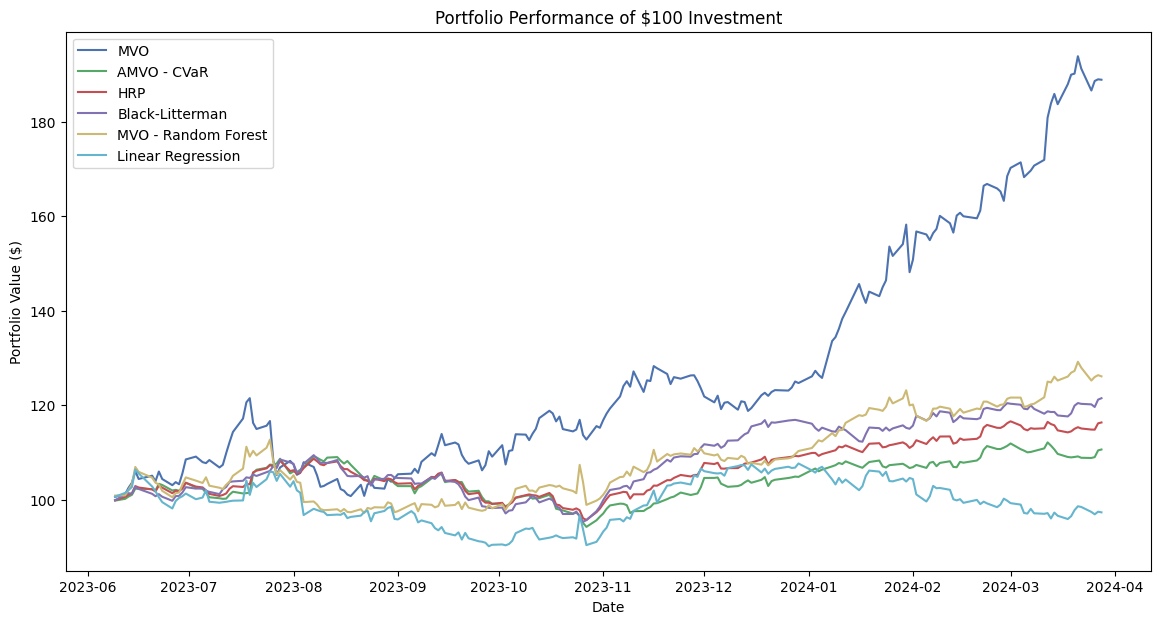

In [ ]:
# Prepare cumulative returns dictionary
cumulative_returns_dict = {
    "MVO": cumulative_returns_mvo,
    "AMVO - CVaR": cumulative_returns_cvar,
    "HRP": cumulative_returns_hrp,
    "Black-Litterman": cumulative_returns_bl,
    "MVO - Random Forest": cumulative_returns_rf,
    "Linear Regression": cumulative_returns_lr
}

# Plot results
plot_results(cumulative_returns_dict, test_dates)

We defined a function to plot the portfolio distribution using bar plots. This function takes a dictionary of weights for different models and generates a subplot for each model's portfolio distribution. Each subplot is a bar plot showing the weights of various stocks in the portfolio. The function labels the x-axis with the stock names, the y-axis with the weight values, and includes a horizontal line at zero for reference. After setting up the subplots, we ensured they were neatly arranged using tight_layout. Finally, we called this function with a dictionary containing the portfolio weights for various models, including MVO, AMVO - CVaR, HRP, Black-Litterman, Random Forest, and Linear Regression, to visualize their portfolio distributions.

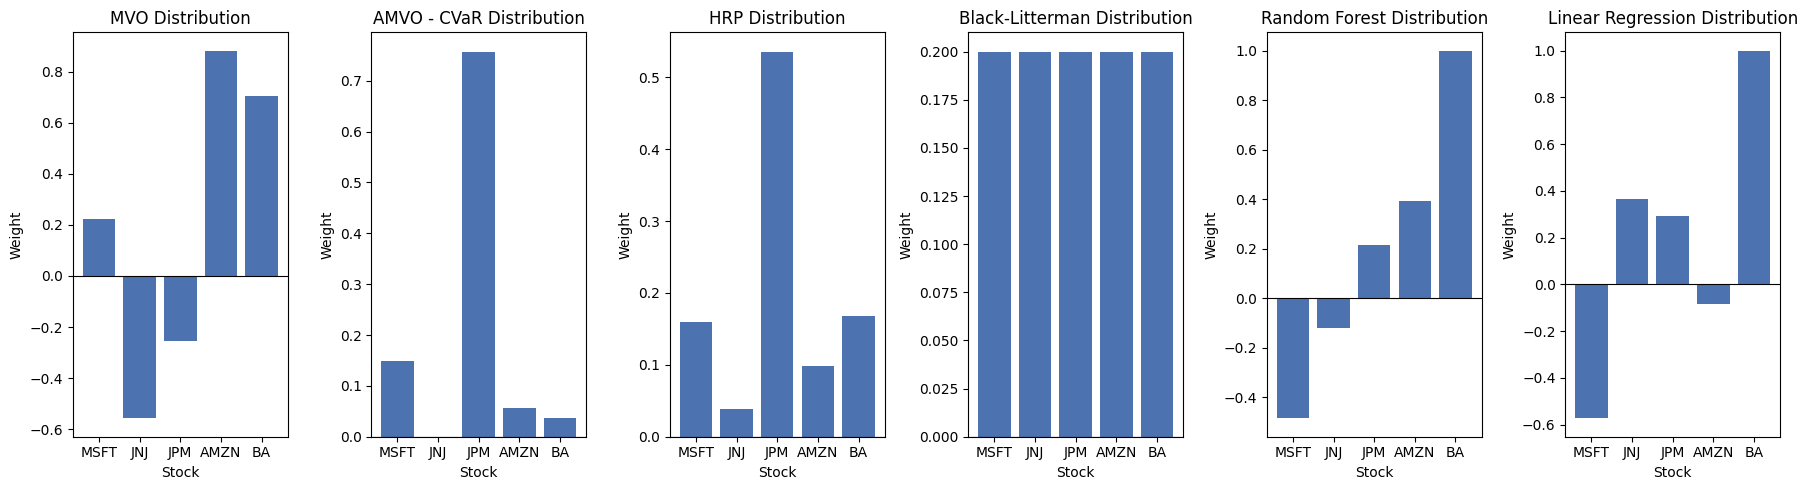

In [ ]:
# Plot portfolio distribution using bar plots
def plot_portfolio_distribution(weights_dict):
    """
    Plot portfolio distribution for different models

    Args:
        weights_dict (dict): Dictionary with model names (keys) and weight arrays (values)

    Returns:
        None
    """
    fig, ax = plt.subplots(1, len(weights_dict), figsize=(18, 5))
    for i, (model, weights) in enumerate(weights_dict.items()):
        ax[i].bar(diversified_list, weights)
        ax[i].set_title(f'{model} Distribution')
        ax[i].set_ylabel('Weight')
        ax[i].set_xlabel('Stock')
        ax[i].axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

weights_dict = {
    "MVO": optimal_weights_mvo,
    "AMVO - CVaR": list(cleaned_weights_cvar.values()),
    "HRP": list(hrp_weights.values()),
    "Black-Litterman": list(cleaned_weights_bl.values()),
    "Random Forest": optimal_weights_rf,
    "Linear Regression": optimal_weights_lr
}

plot_portfolio_distribution(weights_dict)

We also defined a function to plot the expected returns and risk of the portfolio. This function takes the expected returns and covariance matrix as inputs and generates a scatter plot. In the plot, the x-axis represents the risk, measured as the standard deviation (the square root of the diagonal elements of the covariance matrix), and the y-axis represents the expected returns. Each stock in the portfolio is plotted as a blue marker, and labeled with its name for clarity. The plot is titled "Expected Returns and Risk," and the x and y axes are labeled accordingly. A grid is added for better readability. Finally, we called this function with the expected returns from the LSTM model and the covariance matrix to visualize the expected returns and associated risk of the portfolio.

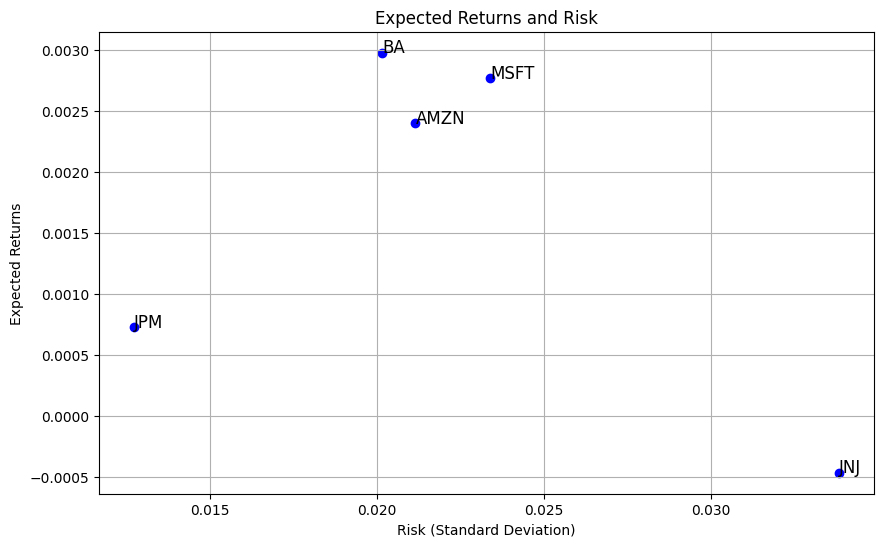

In [ ]:
# Plot expected returns and risk
def plot_expected_returns_and_risk(expected_returns, cov_matrix):
    """
    Plot expected returns and risk for portfolio

    Args:
        expected_returns (np array): array of expected returns
        cov_matrix (np array): covariance matrix of returns

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(np.sqrt(np.diag(cov_matrix)), expected_returns, c='blue', marker='o')
    plt.title('Expected Returns and Risk')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Expected Returns')
    for i, txt in enumerate(diversified_list):
        plt.annotate(txt, (np.sqrt(np.diag(cov_matrix))[i], expected_returns[i]), fontsize=12)
    plt.grid(True)
    plt.show()

plot_expected_returns_and_risk(expected_returns_lstm, cov_matrix)

Next, We defined a function which utilizes the EfficientFrontier class from the pypfopt library to calculate the efficient frontier. We created a figure and axis for the plot, and used the plot_efficient_frontier method from the plotting module to visualize it, with asset points shown on the plot. Finally, we called this function with the expected returns from the LSTM model and the covariance matrix to display the efficient frontier of the portfolio.

The efficient frontier represents a set of optimal portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of expected return. Derived from mean-variance optimization, it evaluates asset combinations based on their expected returns and risk measures. Portfolios on the efficient frontier are efficient, as no other portfolio provides a better return for the same risk or lower risk for the same return. Investors use the efficient frontier to balance risk and return when constructing their portfolios.








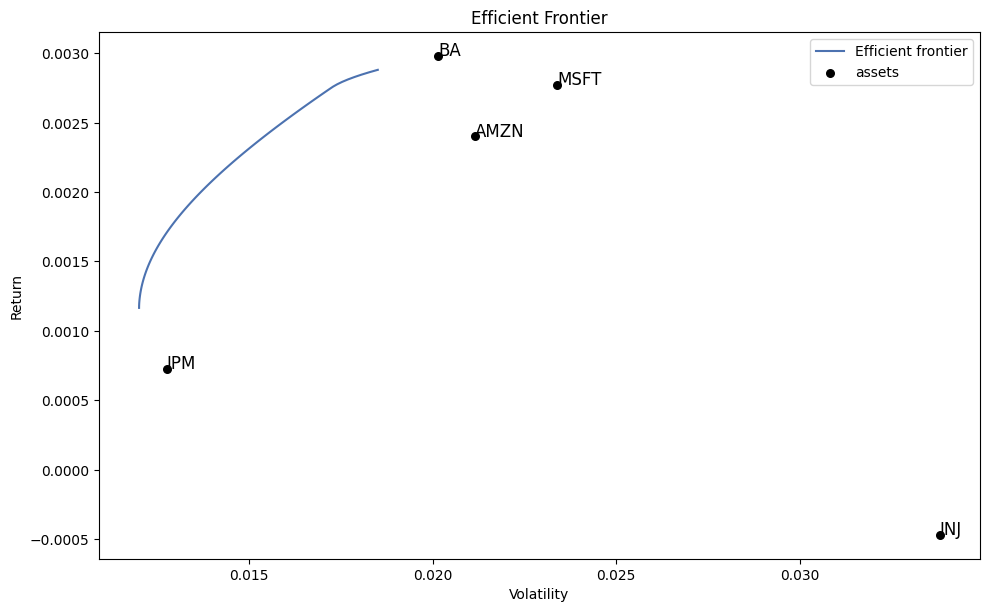

In [ ]:
# Plot the efficient frontier
def plot_efficient_frontier(expected_returns, cov_matrix):
    """
    Plot the efficient frontier for the portfolio

    Args:
        expected_returns (np array): array of expected returns
        cov_matrix (np array): covariance matrix of returns

    Returns:
        None
    """
    ef = EfficientFrontier(expected_returns, cov_matrix)
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    for i, txt in enumerate(diversified_list):
        plt.annotate(txt, (np.sqrt(np.diag(cov_matrix))[i], expected_returns[i]), fontsize=12)
    ax.set_title('Efficient Frontier')
    plt.show()

plot_efficient_frontier(expected_returns_lstm, cov_matrix)

Finally, We used a function to plot the stock correlation matrix based on the returns data. This function calculates the correlation matrix of the returns and then visualizes it using a heatmap. The heatmap is created with a color map ranging from cool to warm colors, displaying correlation values with annotations formatted to two decimal places.

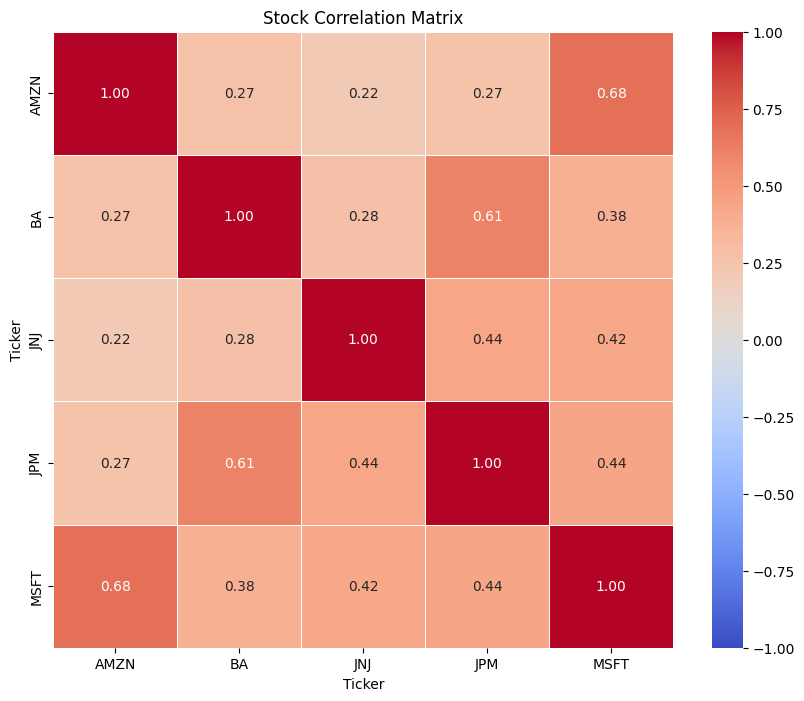

In [ ]:
# Plot stock correlation matrix
def plot_stock_correlation(returns):
    """
    Plot correlation matrix of stock returns

    Args:
        returns (pd DataFrame): DataFrame of stock returns

    Returns:
        None
    """
    plt.figure(figsize=(10, 8))
    corr = returns.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmax=1, vmin=-1)
    plt.title('Stock Correlation Matrix')
    plt.show()

plot_stock_correlation(returns)

# Additional Examples using other stock combinations
We then applied the same approach and models to two additional stock combinations. Listed at data importing section. We wanted the model to apply to any combinations of stocks to help project the optimial future combinations. Investors can use this model to help determine how they should allocate their assets.

# Conclusion
This project aimed to evaluate the performance of different portfolio optimization techniques using machine learning models on selected stocks. Three example set of stocks were used: combination of various companies from various industries, combiantion of tech companies, and combination of consumer and retail companies. The models tested include Mean-Variance Optimization (MVO), Advanced Mean-Variance Optimization using Conditional Value at Risk (AMVO-CVaR), Hierarchical Risk Parity (HRP), Black-Litterman, Random Forest, and Linear Regression.

1. **Model Portfolio Description**:
    - **Random Forest Model**: The portfolio optimized using the Random Forest model
    - **Mean-Variance Optimization (MVO)**:
    - **Advanced Mean-Variance Optimization (AMVO-CVaR)**:
    - **Hierarchical Risk Parity (HRP)**: HRP model inherently limits risk by considering hierarchical clustering of assets.
    - **Black-Litterman Model**: This model serves as the banch mark by allocating equal weights to all selected stocks.
    - **Linear Regression**: The model is based on linear regression predictions


2. **Model Performance**:
    - Black-Litterman’s balanced weight distribution serves as the baseline for this project as it simply allocates equal weights to all stocks and does not need complex projections.
    - The performance of different machine learning models varies based on different datasets. For example, HRP MVO, and random forest tend to perform better for the mixed data set, HRP tend to perform better for tech companies, and random forest tend to perform better for consumer companies.
    - This variation in performance might be attributed to the different industry sectors involved, which have different market conditions. As a result, different models may be better at projecting volaility or return for different sectors.

2. **Real-World Application**:
    - The findings highlight the importance of model selection based on different sector and market conditions.
    - Machine learning models is shown to offer a significant advantages in return prediction and portfolio optimization when compared to the baseline; however, it also require careful implementation and further fine tuning.
    - Investors can determine the best model and explore projection methods based on their specific portfolio composition.

3. **Future Work**:
    - Further research can explore the integration of additional market factors in addition to closing price, which would help more accurately project future volatility and returns.
    - More fine tuned machine learning models can be tested on each sector, which may need different projection methods.
    - Implementing the models in live trading scenarios can also provide more insights into their practical use and areas of improvement.

In conclusion, this project demonstrated the potential of using advanced machine learning models to enhance portfolio performance while managing risk. Machine learning can be extremely valuable in helping portfolio managers in determining their portfolio weight composition, which further enhances performance.







